# Functions


In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from mpl_toolkits.mplot3d import Axes3D  # 3D projection
import numpy as np

In [58]:
# parameters
dt = 0.1  # time step
t_end = 30  # total time
t0 = 0  # initial time
N = int(t_end / dt)  # number of time steps
M = 1
device = "cuda" if torch.cuda.is_available() else "cpu"

## VDP System

In [59]:
# ----------------------------
# Van der Pol System (device-safe)
# ----------------------------
def vdp(y, mu=1.0):
    return torch.stack([
        y[1],
        mu * (1 - y[0]**2) * y[1] - y[0]
    ]).to(y)

# ----------------------------
# General RK Integrator (Explicit & Implicit)
# ----------------------------
def rk_apply(butcher, x, dt, f, max_iter=10, tol=1e-8):
    A = torch.tensor(butcher['A'], dtype=x.dtype, device=x.device)
    b = torch.tensor(butcher['b'], dtype=x.dtype, device=x.device)

    s = len(b)
    d = x.shape[0]
    k = torch.zeros((s, d), dtype=x.dtype, device=x.device)

    for i in range(s):
        k_i = k[i].clone()


        #The is a banach iterator and I should try a newton method instead
        def G(ki_guess):
            weighted_sum = sum(A[i, j] * (ki_guess if j == i else k[j]) for j in range(s))
            return f(x + dt * weighted_sum)

        for _ in range(max_iter):
            ki_new = G(k_i)
            if torch.norm(ki_new - k_i) < tol:
                break
            k_i = ki_new

        k[i] = k_i

    x_next = x + dt * torch.sum(b.view(-1, 1) * k, dim=0)
    return k, x_next

# ----------------------------
# Training Data Generation
# ----------------------------
def generate_training_data(func, y0, t0, t_end, dt=dt, butcher=None, mu=1.0, M = M, device="cpu"):
    """
    Integrate using rk_apply and collect (x_n, k_n) pairs for NN training.
    """

    if butcher is None:
        raise ValueError("Butcher tableau must be provided.")
    
    N = int((t_end - t0) / dt) + 1
    
    x = y0.to(device)
    d = x.shape[0]
    s = len(butcher['b'])

    X = torch.zeros((N, d), dtype=torch.float32, device=device)
    K = torch.zeros((N, s, d), dtype=torch.float32, device=device)

    for n in range(N):
        X[n] = x
        k, x_next = rk_apply(butcher, x, dt/M, lambda y: func(y, mu=mu))
        for i in range(M-1):
            k, x_next = rk_apply(butcher, x_next, dt/M, lambda y: func(y, mu=mu))
        K[n] = k
        x = x_next

    return X, K

def generate_training_data_all_ics(func, y0s, t0, t_end, dt, butcher, mu=1.0, M = M, device="cpu"):
    data = []
    for y0 in y0s:
        X, K = generate_training_data(func, y0, t0, t_end, dt, butcher, mu=mu, M=M, device=device)
        data.append((X, K))

    X_all = torch.cat([pair[0] for pair in data], dim=0)
    K_all = torch.cat([pair[1] for pair in data], dim=0)
    return X_all, K_all

## NN Class

In [60]:
import os

# ----------------------------
# Neural Network RK Stage Predictor
# ----------------------------
class NeuralRK(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, num_layers=3, output_dim=2, butcher=None):
        super().__init__()
        if butcher is None:
            butcher = {
                'A': [
                    [0.0, 0.0, 0.0, 0.0],
                    [0.5, 0.0, 0.0, 0.0],
                    [0.0, 0.5, 0.0, 0.0],
                    [0.0, 0.0, 1.0, 0.0]
                ],
                'b': [1/6, 1/3, 1/3, 1/6],
                'c': [0.0, 0.5, 0.5, 1.0]
            }
        self.butcher = butcher
        self.s = len(butcher['b'])
        self.dt = dt
        self.output_dim = output_dim

        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers += [nn.Linear(hidden_dim, self.s * output_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.net(x)
        return out.view(batch_size, self.s, self.output_dim)

    def loss_fn(self, x, k_true):
        k_pred = self.forward(x)
        return F.mse_loss(k_pred, k_true)
    
    def save_model(self, system_name, scheme):

        if system_name == "LHCb":
            save_dir = os.path.join("Results", "LHCb", "Models")
        elif system_name == "VDP":
            save_dir = os.path.join("Results", "VDP", "Models")
        else:
            raise ValueError("Unknown system_name: " + system_name)

        os.makedirs(save_dir, exist_ok=True)

        model_info = {
            "num_layers": len(self.net),
            "hidden_dim": self.net[0].out_features,
            "system_name": system_name
        }
        filename = f"NeuralRK_{system_name}_hd{model_info['hidden_dim']}_layers{model_info['num_layers']}_dt{self.dt}_{scheme}.pt"

        torch.save(
            {"model_state_dict": self.state_dict(), "model_info": model_info},
            os.path.join(save_dir, filename)
        )
        print(f"Model saved to {os.path.join(save_dir, filename)}")

## Rollouts

In [61]:
@torch.no_grad()
def rollout_neural_model(model, x0, steps, dt):
    """
    Use the trained NeuralRK model to generate a trajectory.
    """
    model.eval()
    x = x0.unsqueeze(0)  # shape: (1, 2)
    trajectory = [x.squeeze(0).cpu()]

    for _ in range(steps):
        k_pred = model(x)  # shape: (1, s, d)
        b = torch.tensor(model.butcher['b'], dtype=k_pred.dtype, device=k_pred.device).view(1, -1, 1)
        x_next = x + dt * torch.sum(b * k_pred, dim=1)
        x = x_next
        trajectory.append(x.squeeze(0).cpu())

    return torch.stack(trajectory)  # shape: (steps+1, d)

@torch.no_grad()
def rollout_rk4(x0, steps, dt, M, butcher, f):
    """
    Integrate using classical RK method.
    """
    x = x0.clone()
    trajectory = [x.cpu()]
    for _ in range(steps):
        k, x_next = rk_apply(butcher, x, dt/M, f)
        for i in range(M-1):
            k, x_next = rk_apply(butcher, x_next, dt/M, f)
        x = x_next
        trajectory.append(x.cpu())
    return torch.stack(trajectory)  # shape: (steps+1, d)

## Analysis functions

In [62]:
@torch.no_grad()
def evaluate_final_error(model, rk_func, butcher, f, x0_set, t_end, dt):
    """
    Compute the final-time error |NN(t_end) - RK(t_end)| for a batch of initial conditions.

    Args:
        model: Trained NeuralRK model
        rk_func: Classical RK function (e.g., rk_apply)
        butcher: RK Butcher tableau
        f: Vector field function (e.g., vdp)
        x0_set (Tensor): shape (batch_size, 2), initial conditions
        t_end (float): Final time
        dt (float): Step size

    Returns:
        errors (Tensor): shape (batch_size,), final state L2 error for each initial condition
    """
    model.eval()
    steps = int(t_end / dt)
    errors = []

    for x0 in x0_set:
        x0 = x0.to(model.net[0].weight.device)

        # Neural rollout
        traj_nn = rollout_neural_model(model, x0, steps, dt)
        x_nn_final = traj_nn[-1]

        # Classical RK rollout
        traj_rk = rollout_rk4(x0, steps, dt, M , butcher, f)
        x_rk_final = traj_rk[-1]

        # Compute final error
        err = torch.norm((x_nn_final - x_rk_final)/x_nn_final, p=2)
        errors.append(err.item())

    return torch.tensor(errors)


# Van Der Pole

## VDP Data

In [ ]:
rk4 = {
    'A': [
        [0.0, 0.0, 0.0, 0.0],
        [0.5, 0.0, 0.0, 0.0],
        [0.0, 0.5, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0]
    ],
    'b': [1/6, 1/3, 1/3, 1/6],
    'c': [0.0, 0.5, 0.5, 1.0]
}

# x0s = [torch.tensor([2.0, 0.0], dtype=torch.float32).to(device) + torch.tensor([0.1, 0.1], dtype=torch.float32).to(device) * i for i in range(10)]

# x0 = torch.tensor([2.0, 0.0], dtype=torch.float32).to(device)

# Define the domain bounds and number of grid points per dimension
x_min, x_max = -2.0, 2.0
y_min, y_max = -2.0, 2.0
num_points = 10  # number of grid points per axis

# Create a grid of points
x_vals = torch.linspace(x_min, x_max, steps=num_points, device=device) 
y_vals = torch.linspace(y_min, y_max, steps=num_points, device=device)

# Use meshgrid; note: use `indexing="ij"` if you want the first dimension to be x and second to be y
xx, yy = torch.meshgrid(x_vals, y_vals, indexing="ij")
# Stack and flatten the grid to get a tensor of shape (num_points*num_points, 2)
x0s = torch.stack((xx, yy), dim=-1).view(-1, 2)

# Generate training data
X, K = generate_training_data_all_ics(vdp, x0s, t0=t0, t_end=t_end, dt=dt, butcher=rk4, M = M, device=device)

torch.save((X.cpu(), K.cpu()), f"Data/VDP/VDP_Training.pt")

### VDP Data load in

In [64]:
X_loaded, K_loaded = torch.load("Data/VDP/VDP_Training.pt")

X, K = X_loaded.to(device), K_loaded.to(device)

### VDP Example training

In [ ]:
# 1) Select device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 2) RK4 tableau
rk4 = {
    "A": [
        [0.0, 0.0, 0.0, 0.0],
        [0.5, 0.0, 0.0, 0.0],
        [0.0, 0.5, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0],
    ],
    "b": [1/6, 1/3, 1/3, 1/6],
    "c": [0.0, 0.5, 0.5, 1.0],
}

# 3) Create model & optimizer
model     = NeuralRK(hidden_dim=64, num_layers=3, butcher=rk4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 4) Make sure your training data X,K are on the same device
X = X.to(device)
K = K.to(device)

# 5) Convergence parameters
min_epochs = 100
patience   = 20
delta_tol  = 1e-6
max_epochs = 100000     # safety cap
batch_size = 64

best_loss = float("inf")
wait      = 0
epoch     = 0

# 6) Training loop
while True:
    # Sample a random batch (on-device)
    idx = torch.randperm(X.size(0), device=device)[:batch_size]
    x_batch = X[idx]
    k_batch = K[idx]

    optimizer.zero_grad()
    loss = model.loss_fn(x_batch, k_batch)
    loss.backward()
    optimizer.step()

    loss_val = loss.item()

    # Initialize best_loss on the first epoch
    if epoch == 0:
        best_loss = loss_val

    # Logging
    if epoch % 100 == 0:
        print(f"Epoch {epoch:5d} | Loss = {loss_val:.6e} | Best = {best_loss:.6e} | Wait = {wait}")

    # Check convergence once we've done min_epochs
    if epoch >= min_epochs:
        if abs(loss_val - best_loss) < delta_tol:
            wait += 1
            if wait >= patience:
                print(f"\nConverged at epoch {epoch} | loss = {loss_val:.6e}")
                break
        else:
            best_loss = loss_val
            wait = 0

    epoch += 1
    if epoch >= max_epochs:
        print("\nStopping early: reached max epochs.")
        break

# Save the model
if not os.path.exists("RK_PINNs/Results/VDP/Models"):
    os.makedirs("RK_PINNs/Results/VDP/Models")

model.save_model("VDP", "RK4")



Using device: cuda
Epoch     0 | Loss = 3.302811e+00 | Best = 3.302811e+00 | Wait = 0
Epoch   100 | Loss = 2.984888e-01 | Best = 3.302811e+00 | Wait = 0
Epoch   200 | Loss = 5.601625e-02 | Best = 7.063195e-02 | Wait = 0
Epoch   300 | Loss = 2.041467e-02 | Best = 1.127568e-02 | Wait = 0
Epoch   400 | Loss = 2.242840e-02 | Best = 4.291826e-02 | Wait = 0
Epoch   500 | Loss = 8.555625e-03 | Best = 6.970650e-03 | Wait = 0
Epoch   600 | Loss = 3.052952e-02 | Best = 6.793131e-02 | Wait = 0
Epoch   700 | Loss = 3.990791e-02 | Best = 6.606699e-02 | Wait = 0
Epoch   800 | Loss = 3.992762e-03 | Best = 8.947220e-03 | Wait = 0
Epoch   900 | Loss = 1.284331e-02 | Best = 1.343397e-02 | Wait = 0
Epoch  1000 | Loss = 6.561842e-03 | Best = 1.039786e-02 | Wait = 0
Epoch  1100 | Loss = 5.141874e-03 | Best = 2.286095e-03 | Wait = 0
Epoch  1200 | Loss = 1.121890e-02 | Best = 3.336526e-03 | Wait = 0
Epoch  1300 | Loss = 7.300695e-03 | Best = 1.222039e-02 | Wait = 0
Epoch  1400 | Loss = 3.529939e-03 | Best = 

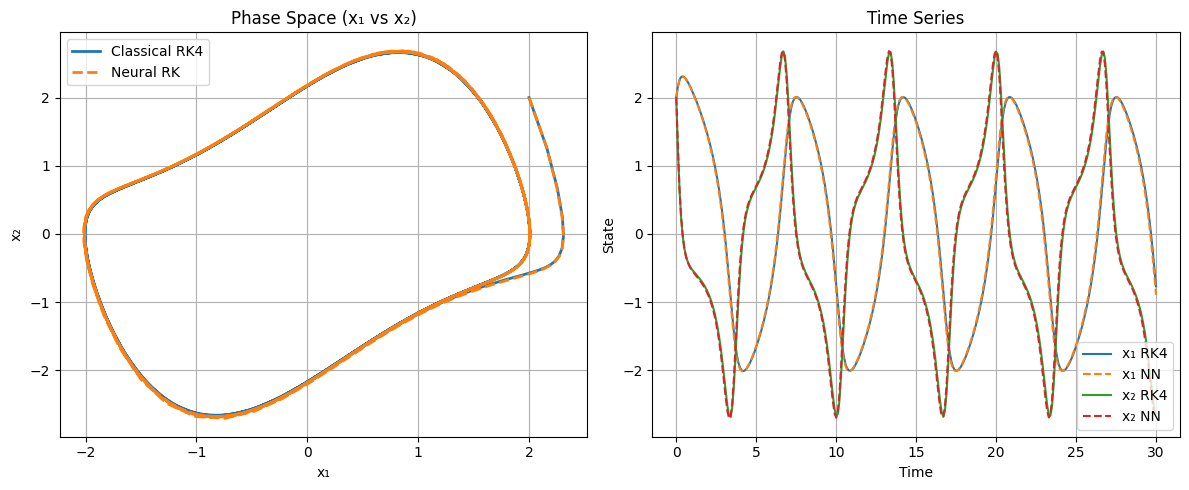

In [ ]:
# === Parameters ===
steps = N
x0 = torch.tensor([2,2], dtype=torch.float32).to(device)

# === Rollouts ===
traj_nn = rollout_neural_model(model, x0, steps, dt)
traj_rk = rollout_rk4(x0, steps, dt, 100, rk4, vdp)

# === Plot ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(traj_rk[:, 0], traj_rk[:, 1], label="Classical RK4", lw=2)
plt.plot(traj_nn[:, 0], traj_nn[:, 1], '--', label="Neural RK", lw=2)
plt.title("Phase Space (x₁ vs x₂)")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
t = torch.arange(steps + 1) * dt
plt.plot(t, traj_rk[:, 0], label="x₁ RK4")
plt.plot(t, traj_nn[:, 0], '--', label="x₁ NN")
plt.plot(t, traj_rk[:, 1], label="x₂ RK4")
plt.plot(t, traj_nn[:, 1], '--', label="x₂ NN")
plt.title("Time Series")
plt.xlabel("Time")
plt.ylabel("State")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Generate multiple initial conditions
n_ic = 20
x0_set = torch.stack([
    torch.tensor([torch.rand(1).item() * 4 - 2, torch.rand(1).item() * 4 - 2])
    for _ in range(n_ic)
])

# Compute errors
errors = evaluate_final_error(
    model=model,
    rk_func=rk_apply,
    butcher=rk4,
    f=vdp,
    x0_set=x0_set,
    t_end=dt,
    dt=0.1
)

# Report
print("Mean final-time error:", errors.mean().item())
print("Max final-time error: ", errors.max().item())


Mean final-time error: 0.007982257753610611
Max final-time error:  0.09744223207235336


## Comparing Architectures

In [67]:
# === Configurations ===
hidden_dims = [i**2 for i in range(1,5)] 
num_layers_list = [1, 3, 5, 6]
repeats = 1  # optional repeat per config


dt = 0.1
steps = N
device = "cuda" if torch.cuda.is_available() else "cpu"

results = []

# Convergence criterion parameters:
max_epochs = 100000         # Maximum training epochs allowed
tol = 1e-6                 # Minimum loss improvement required
patience = 20              # Number of epochs without improvement to wait

# === Evaluation Initial Conditions ===
def sample_initial_conditions(n):
    return torch.stack([
        torch.tensor([torch.rand(1).item() * 4 - 2, torch.rand(1).item() * 4 - 2])
        for _ in range(n)
    ])

x0_eval = sample_initial_conditions(20).to(device)

# === Loop over Configurations ===
for hidden_dim, num_layers in product(hidden_dims, num_layers_list):
    print(f"Training model with hidden_dim={hidden_dim}, num_layers={num_layers}")
    

    # Initialize model and optimizer
    model = NeuralRK(hidden_dim=hidden_dim, num_layers=num_layers, butcher=rk4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    

  # Training loop with convergence
    min_epochs = 100
    patience = 20
    delta_tol = 1e-6

    best_loss = float('inf')
    wait = 0
    epoch = 0
    max_epochs = 100000  # safety cap

    while True:
        idx = torch.randperm(X.size(0))
        x_batch = X[idx[:64]]
        k_batch = K[idx[:64]]

        optimizer.zero_grad()
        loss = model.loss_fn(x_batch, k_batch)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()

        if epoch % 100 == 0:
            print(f"Epoch {epoch:4d}: Loss = {loss_val:.6f}")

        if epoch >= min_epochs:
            if abs(loss_val - best_loss) < delta_tol:
                wait += 1
                if wait >= patience:
                    print(f"Converged after {epoch} epochs with loss {loss_val:.6f}")
                    break
            else:
                wait = 0
                best_loss = loss_val

        epoch += 1
        if epoch >= max_epochs:
            print("Stopped early: max epochs reached.")
            break
    
    print(f"Converged in {epoch} epochs with best loss {best_loss:.4e}")
    # Save the model
    model.save_model("VDP", "RK4")
    
    
    # Evaluate final error
    errors = evaluate_final_error(
        model=model,
        rk_func=rk_apply,
        butcher=rk4,
        f=vdp,
        x0_set=x0_eval,
        t_end=dt,
        dt=dt
    )
    
    results.append({
        "hidden_dim": hidden_dim,
        "num_layers": num_layers,
        "mean_error": errors.mean().item(),
        "max_error": errors.max().item()
    })

# === Save to CSV ===
df = pd.DataFrame(results)
df.to_csv("rk_nn_evaluation.csv", index=False)
print("\nSaved results to rk_nn_evaluation.csv")
display(df)


Training model with hidden_dim=1, num_layers=1
Epoch    0: Loss = 4.173023
Epoch  100: Loss = 3.042027
Epoch  200: Loss = 3.590190
Epoch  300: Loss = 2.717681
Epoch  400: Loss = 2.604065
Epoch  500: Loss = 2.864494
Epoch  600: Loss = 2.472798
Epoch  700: Loss = 2.496041
Epoch  800: Loss = 2.787609
Epoch  900: Loss = 2.449847
Epoch 1000: Loss = 2.370909
Epoch 1100: Loss = 2.048091
Epoch 1200: Loss = 2.767118
Epoch 1300: Loss = 1.756539
Epoch 1400: Loss = 2.047934
Epoch 1500: Loss = 2.406636
Epoch 1600: Loss = 2.257904
Epoch 1700: Loss = 2.130027
Epoch 1800: Loss = 2.249265
Epoch 1900: Loss = 2.153841
Epoch 2000: Loss = 2.583004
Epoch 2100: Loss = 2.022351
Epoch 2200: Loss = 1.796586
Epoch 2300: Loss = 2.174472
Epoch 2400: Loss = 1.348069
Epoch 2500: Loss = 1.986964
Epoch 2600: Loss = 1.713519
Epoch 2700: Loss = 2.305389
Epoch 2800: Loss = 2.809451
Epoch 2900: Loss = 1.576610
Epoch 3000: Loss = 1.736439
Epoch 3100: Loss = 2.297648
Epoch 3200: Loss = 2.457209
Epoch 3300: Loss = 1.979420
E

,hidden_dim,num_layers,mean_error,max_error
0,1,1,0.188022,0.549683
1,1,3,0.209480,0.665004
2,1,5,0.203322,0.658321
3,1,6,0.187319,0.550532
4,4,1,0.079432,0.371588
5,4,3,0.009809,0.030470
6,4,5,0.016866,0.067949
7,4,6,0.063597,0.215450
8,9,1,0.029075,0.105655
9,9,3,0.006372,0.018689


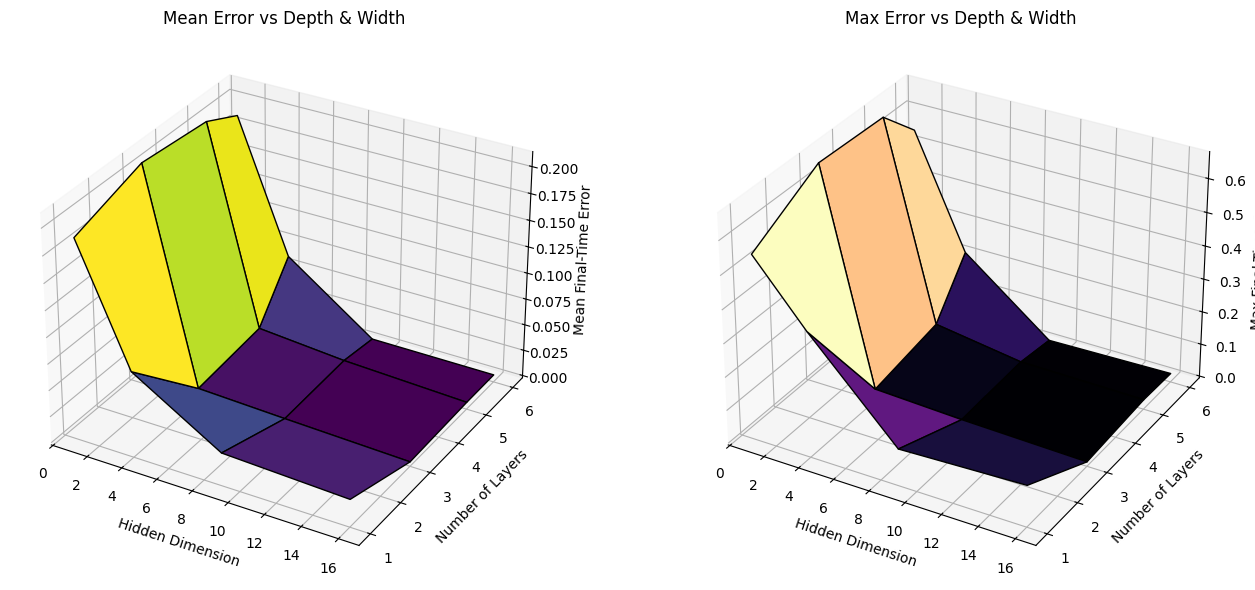

In [70]:
# === Load the CSV ===
df = pd.read_csv("rk_nn_evaluation.csv")

# === Prepare data ===
hidden_dims = sorted(df['hidden_dim'].unique())
num_layers = sorted(df['num_layers'].unique())

H, L = np.meshgrid(hidden_dims, num_layers)

# Reshape mean and max errors into 2D grid
mean_error_grid = np.zeros_like(H, dtype=np.float32)
max_error_grid = np.zeros_like(H, dtype=np.float32)

for i, nl in enumerate(num_layers):
    for j, hd in enumerate(hidden_dims):
        subset = df[(df['hidden_dim'] == hd) & (df['num_layers'] == nl)]
        mean_error_grid[i, j] = subset['mean_error'].mean()
        max_error_grid[i, j] = subset['max_error'].max()

# === Plot mean error surface ===
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(H, L, mean_error_grid, cmap='viridis', edgecolor='k')
ax1.set_xlabel("Hidden Dimension")
ax1.set_ylabel("Number of Layers")
ax1.set_zlabel("Mean Final-Time Error")
ax1.set_title("Mean Error vs Depth & Width")

# === Plot max error surface ===
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(H, L, max_error_grid, cmap='magma', edgecolor='k')
ax2.set_xlabel("Hidden Dimension")
ax2.set_ylabel("Number of Layers")
ax2.set_zlabel("Max Final-Time Error")
ax2.set_title("Max Error vs Depth & Width")

plt.tight_layout()
plt.show()


In [71]:
# Load results from CSV
df = pd.read_csv("rk_nn_evaluation.csv")

# Select model config with lowest mean error
best_row = df.loc[df['mean_error'].idxmin()]
best_hidden = int(best_row['hidden_dim'])
best_layers = int(best_row['num_layers'])

print(f"Best model: hidden_dim = {best_hidden}, num_layers = {best_layers}")


Best model: hidden_dim = 16, num_layers = 3


## dt analysis

Training model for dt = 0.010
Epoch    0: Loss = 3.103731
Epoch  100: Loss = 1.930630
Epoch  200: Loss = 0.602343
Epoch  300: Loss = 0.343108
Epoch  400: Loss = 0.269467
Epoch  500: Loss = 0.226402
Epoch  600: Loss = 0.112078
Epoch  700: Loss = 0.150463
Epoch  800: Loss = 0.127856
Epoch  900: Loss = 0.028580
Epoch 1000: Loss = 0.070070
Epoch 1100: Loss = 0.010687
Epoch 1200: Loss = 0.015137
Epoch 1300: Loss = 0.007432
Epoch 1400: Loss = 0.033056
Epoch 1500: Loss = 0.088670
Epoch 1600: Loss = 0.010840
Epoch 1700: Loss = 0.006474
Epoch 1800: Loss = 0.009182
Epoch 1900: Loss = 0.007458
Epoch 2000: Loss = 0.028003
Epoch 2100: Loss = 0.003929
Epoch 2200: Loss = 0.007553
Epoch 2300: Loss = 0.017489
Epoch 2400: Loss = 0.002344
Epoch 2500: Loss = 0.015081
Epoch 2600: Loss = 0.027550
Epoch 2700: Loss = 0.009448
Epoch 2800: Loss = 0.008783
Epoch 2900: Loss = 0.005332
Epoch 3000: Loss = 0.021374
Epoch 3100: Loss = 0.004693
Epoch 3200: Loss = 0.011567
Epoch 3300: Loss = 0.016386
Epoch 3400: Loss =

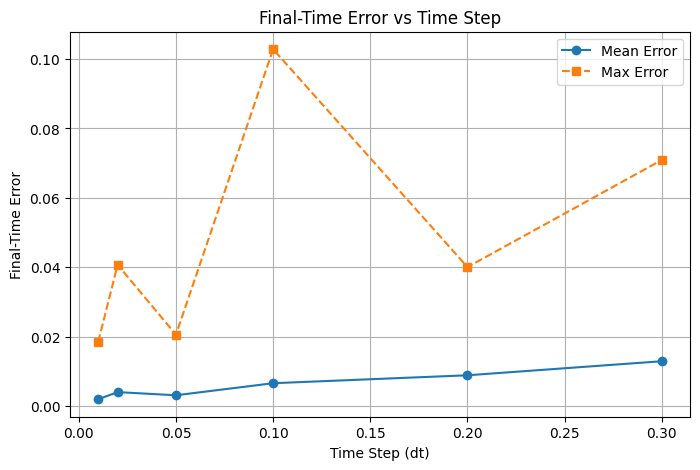

In [69]:
# === Define the best model from above ===
def build_best_model():
    return NeuralRK(hidden_dim=best_hidden, num_layers=best_layers, butcher=rk4).to(device)

# === dt sweep setup ===
dt_values = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
errors_vs_dt = []

# === Evaluation initial conditions (same for all dts) ===
x0_eval = sample_initial_conditions(20).to(device)

# === Train once per dt and evaluate ===
for dt in dt_values:
    print(f"Training model for dt = {dt:.3f}")

    # Build and train model
    model = NeuralRK(hidden_dim=best_hidden, num_layers=best_layers, butcher=rk4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    x0_train = torch.tensor([2.0, 0.0], dtype=torch.float32).to(device)
    
    X, K = generate_training_data_all_ics(vdp, x0s, t0=t0, t_end=t_end, dt=dt, butcher=rk4, device=device)

    # Training loop with convergence
    min_epochs = 100
    patience = 20
    delta_tol = 1e-6

    best_loss = float('inf')
    wait = 0
    epoch = 0
    max_epochs = 100000  # safety cap

    while True:
        idx = torch.randperm(X.size(0))
        x_batch = X[idx[:64]]
        k_batch = K[idx[:64]]

        optimizer.zero_grad()
        loss = model.loss_fn(x_batch, k_batch)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()

        if epoch % 100 == 0:
            print(f"Epoch {epoch:4d}: Loss = {loss_val:.6f}")

        if epoch >= min_epochs:
            if abs(loss_val - best_loss) < delta_tol:
                wait += 1
                if wait >= patience:
                    print(f"Converged after {epoch} epochs with loss {loss_val:.6f}")
                    break
            else:
                wait = 0
                best_loss = loss_val

        epoch += 1
        if epoch >= max_epochs:
            print("Stopped early: max epochs reached.")
            break
    
    print(f"Converged in {epoch} epochs with best loss {best_loss:.4e}")
    # Save the model
    model.save_model("VDP", "RK4")

    # Evaluate error at t_end
    errors = evaluate_final_error(
        model=model,
        rk_func=rk_apply,
        butcher=rk4,
        f=vdp,
        x0_set=x0_eval,
        t_end=dt,
        dt=dt
    )

    errors_vs_dt.append({
        "dt": dt,
        "mean_error": errors.mean().item(),
        "max_error": errors.max().item()
    })

# === Convert to DataFrame & Plot ===
dt_df = pd.DataFrame(errors_vs_dt)
dt_df.to_csv("dt_vs_error.csv", index=False)
print("\nSaved results to dt_vs_error.csv")

plt.figure(figsize=(8, 5))
plt.plot(dt_df['dt'], dt_df['mean_error'], 'o-', label='Mean Error')
plt.plot(dt_df['dt'], dt_df['max_error'], 's--', label='Max Error')
plt.xlabel("Time Step (dt)")
plt.ylabel("Final-Time Error")
plt.title("Final-Time Error vs Time Step")
plt.grid(True)
plt.legend()
plt.show()


## Variable delta t